# Damped Harmonic Oscillator fit

Here, we will model the dynamic structure factor data from Tommy Angelini's videos found [here](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.104.168104), Supplemental Material: compressed_cell_motion.avi. 

Using a *damped harmonic oscillator (DHO) model*, mostly because I'm not sure of what other models exist, so it's a good place to start. The DHO model is as follows:

$$ \frac{S(q,\omega)}{S(q)} = I_0(q) \frac{\frac{1}{2} \Gamma_0(q)}{\omega^2 + (\Gamma_0(q)/2)^2} + I(q) \frac{\Omega(q) \Gamma^2(q)}{(\omega^2 - \Omega^2(q))^2 + \omega^2 \Gamma^2(q)} $$

The first term is the "Rayleigh peak", which quantifies self-diffusivity (this would be the only term present for freely diffusing particles) with:
* amplitude $I_0(q)$
* width $\Gamma_0(q)$

The second term is the "Brillouin peak", which reflects an elastic response to the density fluctuations, with:
* amplitude $I(q)$
* width $\Gamma(q)$
* peak position $\Omega(q)$

This function is defined with `dynamicStructureFactor.sqw.dhoModel`

### Method
Get the normalized dynamic structure factor, $S(q,\omega)/S(q)$, and for each $q$ value, fit the DHO model to the resulting curve (which is a function of $\omega$). We will also cut out the zero frequency (DC) component for the fit. Obtain a goodness of fit ($R^2$) value for each fit along $q$, and see how all the functions of $q$ given above evolve

In [1]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image',cmap='inferno')
%matplotlib notebook

import scipy.optimize as optimization
import scipy as sci
import seaborn as sns

# Custom modules
import dynamicstructurefactor.sqw as sqw
import pytools.mathtools as mts

# output_notebook()
sns.set_style('white')
sns.set_style('ticks', {"xtick.direction": "in","ytick.direction": "in"})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
normedSQW = np.loadtxt('normedSQW.txt', skiprows=1)
qArr = np.loadtxt('qArray.txt', skiprows=1)
wArr = np.loadtxt('wArray.txt', skiprows=1)
dynStructureFactor = np.loadtxt('sqw.txt', skiprows=1)

<IPython.core.display.Javascript object>


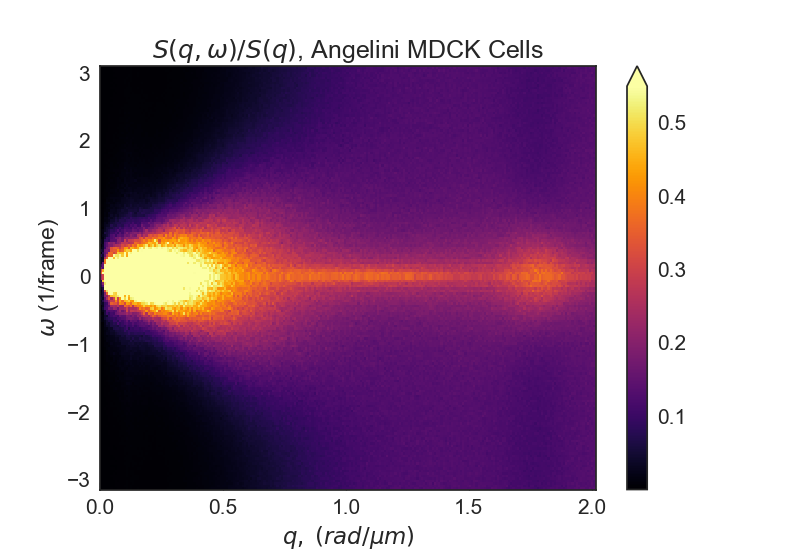

In [3]:
fig, ax = plt.subplots()

cax = ax.pcolor(qArr, wArr[np.where(wArr)], np.squeeze(normedSQW[np.where(wArr),:qArr.size]),
                cmap='inferno',
                vmax = 0.55)

cbar = fig.colorbar(cax, extend='max')

ax.set_title('$S(q,\omega)/S(q)$, Angelini MDCK Cells')
ax.set_ylabel('$\omega$ (1/frame)')
ax.set_xlabel('$q, \; (rad/\mu m)$')

# fig.savefig('fullNormedSQW.tif', format='tif')
# fig.savefig('fullNormedSQW.eps', format='eps')

In [4]:
sofq = sci.integrate.trapz(dynStructureFactor, wArr, axis=0)

<IPython.core.display.Javascript object>


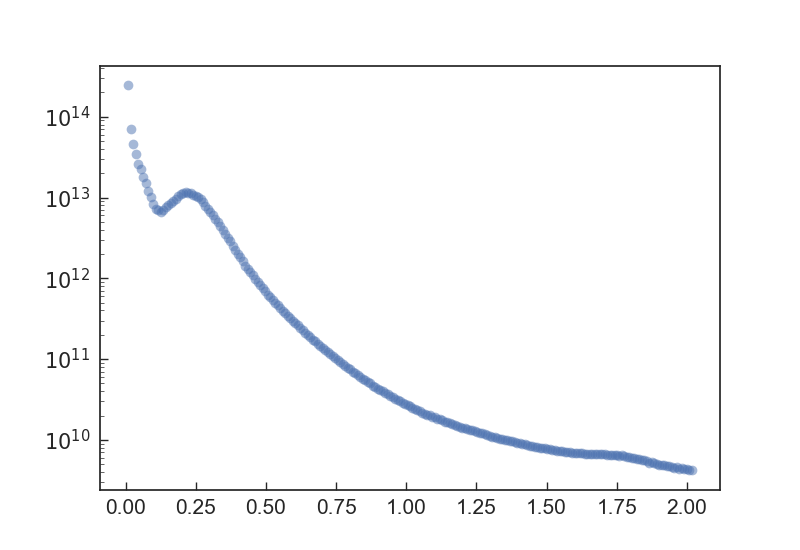

In [5]:
fig, ax = plt.subplots()

ax.plot(qArr[1:], sofq[np.where(qArr)], 'o', alpha = 0.5)
ax.set_yscale('log')

Now perform the fitting over each $q$ slice of $S(q,\omega)/S(q)$ and get the fitted parameters as a function of $q$. A reminder of which parameters are what:

`sqw.dhoModel(w, Gamma0, I0, Gamma, I, Omega)`

Note to take out the DC component of the signal

In [6]:
acIndex = np.where(wArr)

# Initialize arrays for parameters
Gamma0 = np.zeros(qArr.size)
I0 = np.zeros(qArr.size)
Gamma = np.zeros(qArr.size)
I = np.zeros(qArr.size)
Omega = np.zeros(qArr.size)
r2 = np.zeros(qArr.size)

gamma0Init =qArr[np.where(qArr)]
i0Init = np.ones(qArr.size-1)*1e-6
gammaInit = qArr[np.where(qArr)]**2 / sofq[np.where(qArr)]
iInit = np.ones(qArr.size-1)*20
omegaInit = np.ones(qArr.size-1)*5

initialGuesses = np.vstack((gamma0Init, i0Init, gammaInit, iInit, omegaInit))
xdata = wArr[acIndex]

for ii in range(1,qArr.size-1):
    x0 = initialGuesses[:,ii]
    
    # squeeze out extra dimension from slicing the matrix
    ydata = np.squeeze(normedSQW[acIndex, ii])
    optParams, covariance = optimization.curve_fit(sqw.dhoModel, xdata, ydata, x0, maxfev=2000)

    fittedData = sqw.dhoModel(xdata, *optParams)
    
    r2[ii] = mts.rsquared(fittedData, ydata)
    [Gamma0[ii], I0[ii], Gamma[ii], I[ii], Omega[ii]] = optParams
    #print(str(ii))

/Users/Danny/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<IPython.core.display.Javascript object>


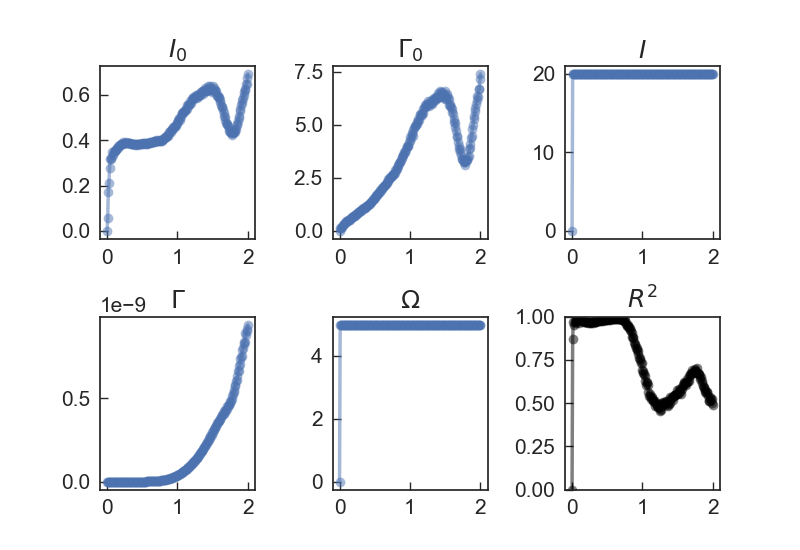

In [7]:
fig, ax = plt.subplots(2,3)#, gridspec_kw={'height_ratios':[4,1]}, sharex=True)


ax[0,0].plot(qArr[:ii], I0[:ii],     '-o', alpha = 0.5, label = '$I_0$'), ax[0,0].set_title('$I_0$'), ax[0,0]. set_xticks([0,1,2])
ax[0,1].plot(qArr[:ii], Gamma0[:ii], '-o', alpha = 0.5, label = '$\Gamma_0$'), ax[0,1].set_title('$\Gamma_0$'), ax[0,1]. set_xticks([0,1,2])
ax[0,2].plot(qArr[:ii], I[:ii],      '-o', alpha = 0.5, label = '$I$'), ax[0,2].set_title('$I$'), ax[0,2]. set_xticks([0,1,2])
ax[1,0].plot(qArr[:ii], Gamma[:ii],  '-o', alpha = 0.5, label = '$ \Gamma $'), ax[1,0].set_title('$\Gamma$'), ax[1,0]. set_xticks([0,1,2])
ax[1,1].plot(qArr[:ii], Omega[:ii],  '-o', alpha = 0.5, label = '$\Omega$'), ax[1,1].set_title('$\Omega$'), ax[1,1]. set_xticks([0,1,2])
ax[1,2].plot(qArr[:ii], r2[:ii], 'k-o', alpha = 0.5, label = '$R^2$'), ax[1,2].set_title('$R^2$'), ax[1,2]. set_xticks([0,1,2])
ax[1,2].set_ylim([0,1])

fig.subplots_adjust(wspace=0.5, hspace = 0.45)

# fig.savefig('angelini_dhoFitParams.tif', format='tif')
# fig.savefig('angelini_dhoFitParams.eps', format='eps')

<IPython.core.display.Javascript object>


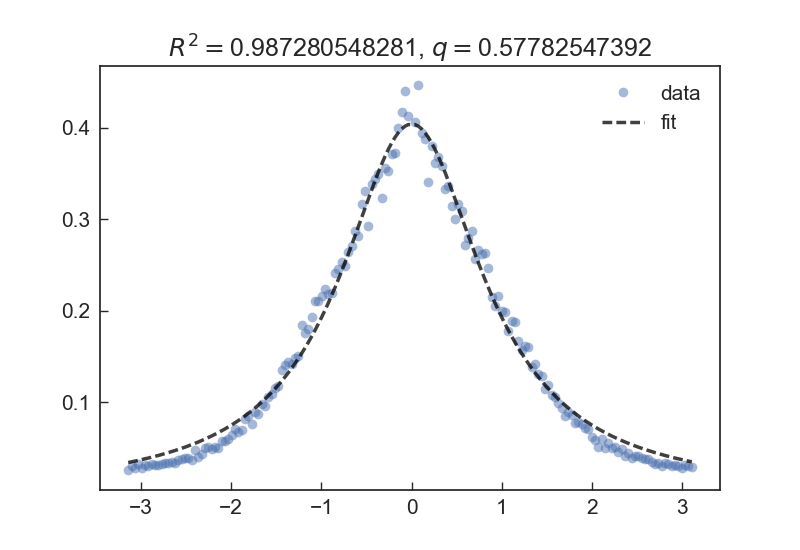

In [8]:
fig, ax = plt.subplots()
n = 65


fittedData = sqw.dhoModel(xdata, Gamma0[n], I0[n], Gamma[n], I[n], Omega[n])

ax.plot(xdata, normedSQW[np.where(wArr),n].T, 'o', alpha = 0.5, label = 'data')
ax.plot(xdata, fittedData, 'k--', alpha = 0.75, label = 'fit')
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_title('$R^2 = $' + str(r2[n]) + ', $q=$' + str(qArr[n]))
plt.legend()

# fig.savefig('angeliniData_fit')

In [9]:
np.where(r2<0.9)

(array([  0,   1,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
        107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
        133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
        146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
        159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
        172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
        185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
        198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
        211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
        224, 225, 226, 227]),)